# Directly Removing the Power Law Before Making the KDE
Now that a decent way to ignore the power law has been found and used in both `Bootstrap-Own-Data.ipynb` and `Emperical-Errors.ipynb`, let's test to see what it does when instead we try to remove the power law much earlier. This will be done for both the bootstrapping method and also the emperical errors method

In [2]:
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import arviz as az
from astropy.cosmology import Planck18
from tqdm import tqdm
import seaborn as sns
from MCMC_functions import *
from astropy.cosmology import units as cu
from astropy import cosmology as cosmo

sns.set_context('notebook')
sns.set_palette('colorblind')

import matplotlib
matplotlib.rcParams['font.family'] = 'serif' # so these plots can go into thesis


%matplotlib inline

Base data that will be used for both methods:

In [3]:
n_sam = int(1e3)
ms = generate_masses(n_sam, f=0.5)
ds = generate_dLs(n_sam)
z = dLs_to_zs(ds)
m_det = ms*(1+z)

Let's quickly see what this data looks like:

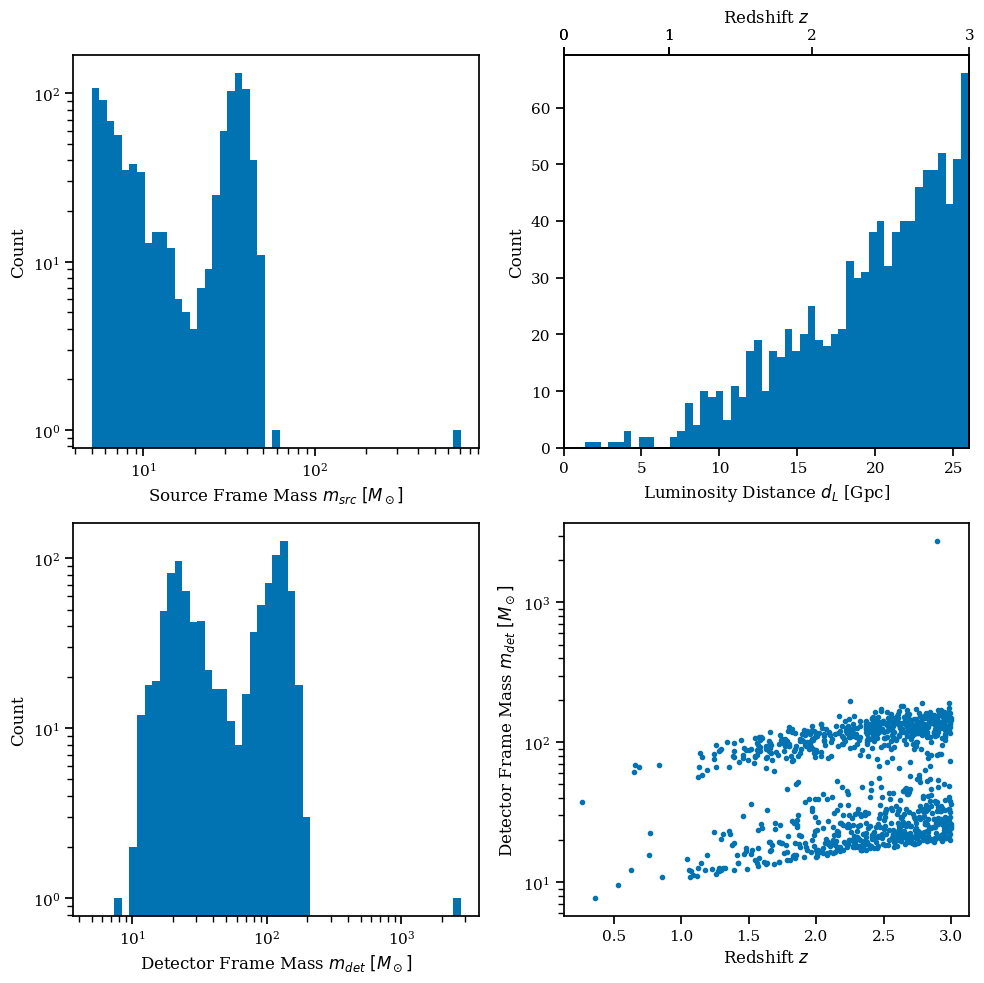

In [4]:
fig = plt.figure(figsize=(10, 10))

### Masses
ax1 = fig.add_subplot(221)
#ax1.set_title("Source Frame Black Hole Mass Function")
ax1.hist(ms, bins=np.logspace(np.log10(5), np.log10(max(ms)), 50))
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel(r"Source Frame Mass $m_{src}$ $[M_\odot]$")
ax1.set_ylabel("Count")

### D_Ls
ax2 = fig.add_subplot(222)
#ax2.set_title("Sample Redshift Distribution")
ax2.hist(ds/1000, bins=50)
ax2.set_xlabel(r"Luminosity Distance $d_L$ [Gpc]")
ax2.set_ylabel("Count")

### Add redshift axis
ax3 = ax2.twiny()
tick_labels = np.linspace(0, 3, 6, dtype=int)
new_tick_locations = Planck18.luminosity_distance(tick_labels)
ax3.set_xticks(new_tick_locations.value)
ax3.set_xticklabels(tick_labels)
ax3.set_xlabel(r"Redshift $z$")
ax2.set_xlim(0, Planck18.luminosity_distance(max(tick_labels)).value/1000)


### Detector frame histogram
ax4 = fig.add_subplot(223)
#ax4.set_title("Detector Frame Mass Function")
ax4.hist(m_det, bins=np.logspace(np.log10(5), np.log10(max(m_det)), 50))
ax4.set_xlabel(r"Detector Frame Mass $m_{det}$ $[M_\odot]$")
ax4.set_ylabel("Count")
ax4.set_xscale('log')
ax4.set_yscale('log')


### Redshift-mass scatter
ax5 = fig.add_subplot(224)
#ax5.set_title("Detector Frame masses vs Redshift")
ax5.scatter(z, m_det, marker='.')
# ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.set_xlabel(r"Redshift $z$")
ax5.set_ylabel(r"Detector Frame Mass $m_{det}$ $[M_\odot]$")


fig.tight_layout()

## Bootstrapping Method
The power law samples will be remove in each bootstrap run after the samples are drawn but before the KDE is made. As you can see in the lower right plot right above, there isn't a hard boundary we can follow, but there is an area that's clearly a little less dense than above or below it that roughly follows $25M_\odot(1+z)$, which is what we'll use as the cutoff. This is imperfect, as there are some in the power law above that cutoff and in the Gaussian below, but it's roughly the correct boundary

In [5]:
def cutoff_mask(mdet, dl, m_min=25):
    '''Helper function for boolean mask to remove power law'''
    return mdet > m_min*(1+cosmo.z_at_value(Planck18.luminosity_distance, dl*u.Mpc))

100%|██████████| 4/4 [00:33<00:00,  8.37s/it]


Text(0.5, 1.0, 'Remove Power Law')

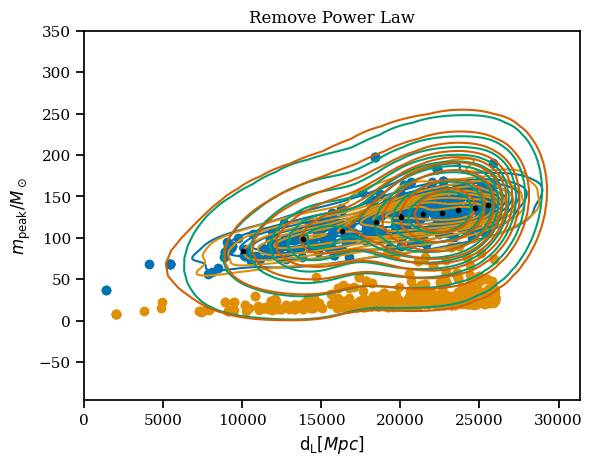

In [15]:
n_events = len(m_det)
n_dLs=10
n_mc = 4
m_min = min(m_det)
m_max = max(m_det)
dL_min = min(ds)
dL_max = max(ds)

m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
dL_cent = np.quantile(ds, np.linspace(0.05, 0.95, n_dLs))

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

for run in tqdm(range(n_mc)):

    events = np.random.randint(n_events, size=n_events)
    
    m_det_mc = m_det[events]
    d_Ls_mc = ds[events]
    m_det_boot = m_det_mc[cutoff_mask(m_det_mc, d_Ls_mc)]
    d_Ls_boot = d_Ls_mc[cutoff_mask(m_det_mc, d_Ls_mc)]
    
    arr = np.array([d_Ls_boot, m_det_boot])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:], mmin=0)
    
    kplot = sns.kdeplot(x=d_Ls_boot, y=m_det_boot)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(d_Ls_boot, m_det_boot)
plt.scatter(d_Ls_mc[~cutoff_mask(m_det_mc, d_Ls_mc)], m_det_mc[~cutoff_mask(m_det_mc, d_Ls_mc)])
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
plt.ylim(top=350)
plt.xlim(left=0)
plt.title("Remove Power Law")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 36 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.


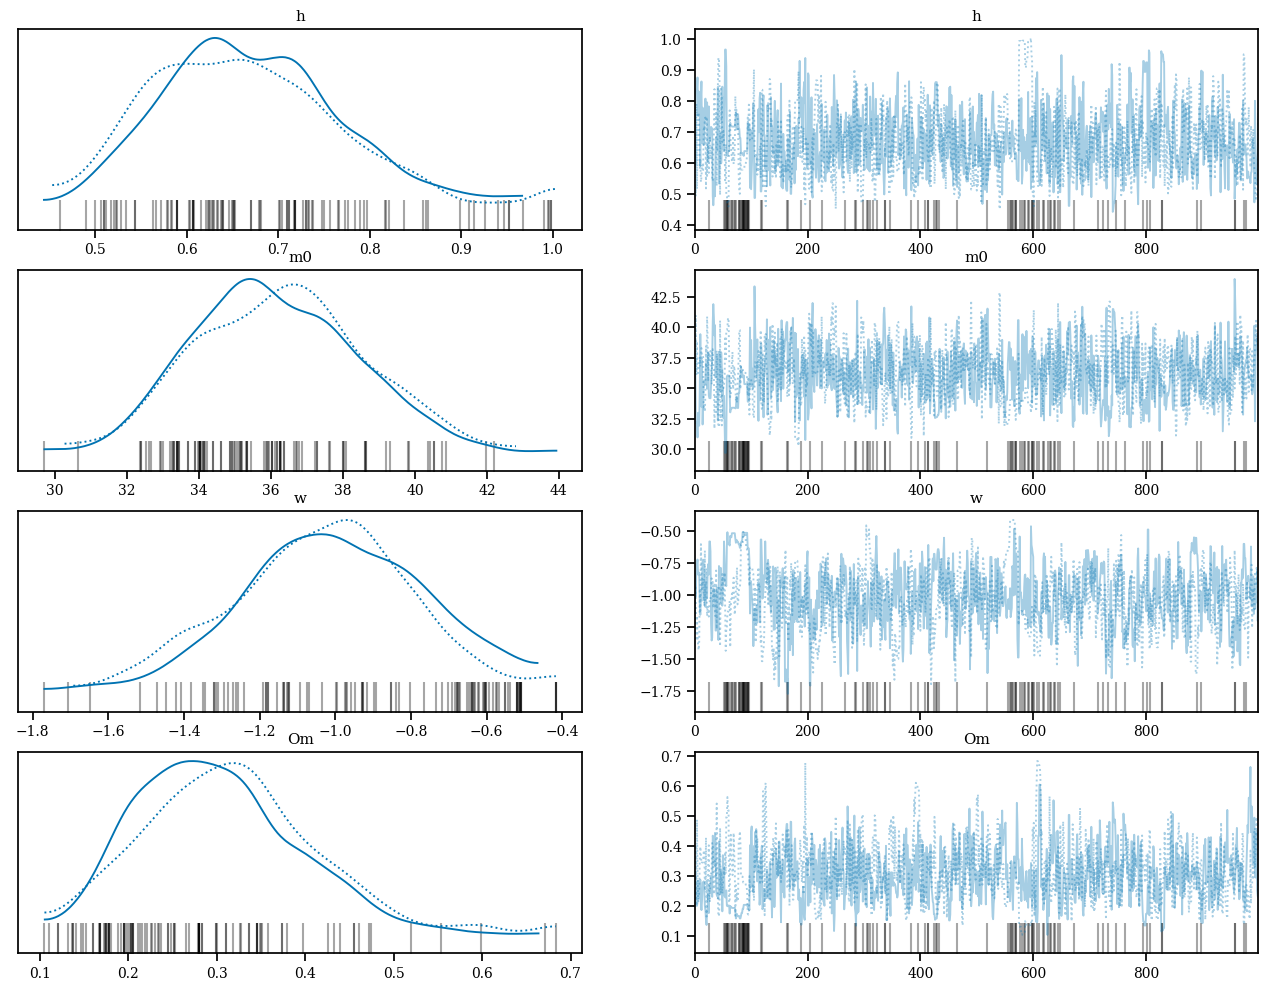

In [7]:
mu_m = np.mean(mpeak_samples, axis=0)
sigma_ms = np.std(mpeak_samples, axis=0)


with make_model(ms_obs=mu_m, sigma_ms_obs=sigma_ms, dls=dL_cent, zmin=0, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'], figsize=(16, 12))
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

## Emperical Errors
Looks like the bootstrapping version worked wonderfully. Now on to the emprical errors version:

In [8]:
m_dls = m_det/ds
sigma_dls = sigma_dL(m_dls)
sigma_ms  = sigma_m(m_dls)

100%|██████████| 4/4 [00:30<00:00,  7.72s/it]


(-98.60177095733658, 250.0)

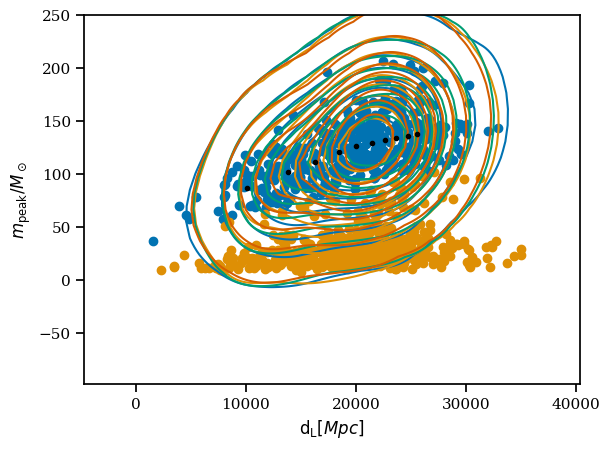

In [9]:
m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
dL_cent = np.quantile(ds, np.linspace(0.05, 0.95, n_dLs))

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

for run in tqdm(range(n_mc)):

    m_det_mc = np.random.lognormal(mean=np.log(m_det), sigma=sigma_ms)
    # print(m_det_mc[0])
    d_Ls_mc = np.random.lognormal(mean=np.log(ds), sigma=sigma_dls)

    d_Ls_err = d_Ls_mc[cutoff_mask(m_det_mc, d_Ls_mc)]
    m_det_err = m_det_mc[cutoff_mask(m_det_mc, d_Ls_mc)]
    
    arr = np.array([d_Ls_err, m_det_err])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        # redshift_min = cosmo.z_at_value(Planck18.luminosity_distance)
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:])
    
    kplot = sns.kdeplot(x=d_Ls_err, y=m_det_err)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(d_Ls_err, m_det_err)
plt.scatter(d_Ls_mc[~cutoff_mask(m_det_mc, d_Ls_mc)], m_det_mc[~cutoff_mask(m_det_mc, d_Ls_mc)])
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
plt.ylim(top=250)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.


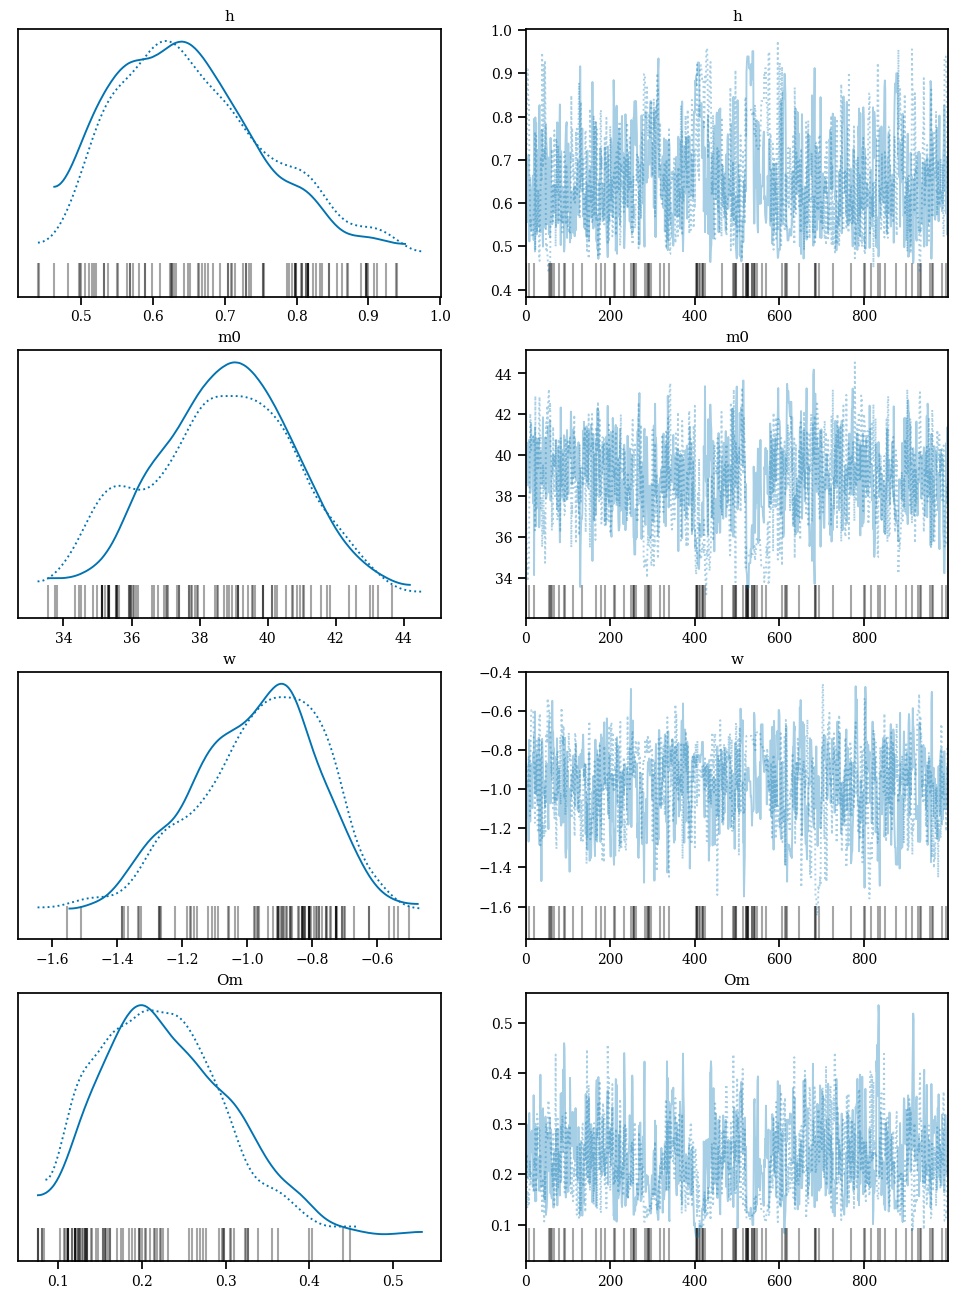

In [10]:
mu_m = np.mean(mpeak_samples, axis=0)
sigmam = np.std(mpeak_samples, axis=0)


with make_model(ms_obs=mu_m, sigma_ms_obs=sigmam, dls=dL_cent, zmin=0, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'], figsize=(12, 16))
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

<ErrorbarContainer object of 3 artists>

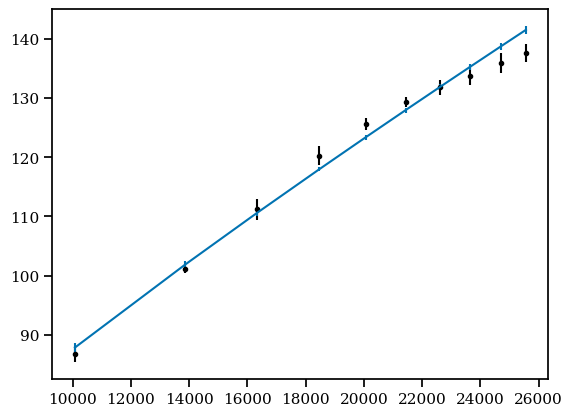

In [11]:
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.errorbar(dL_cent, trace.posterior['m_peak'].mean(dim=['chain', 'draw']), yerr=trace.posterior['m_peak'].std(dim=['chain', 'draw']))